# Pipeline for Behavioral Cloning

In [1]:
import csv
import numpy as np
import sklearn
import cv2
from math import ceil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Loading Datasets

Load image paths and steering measurement. Calculate biased steering for left and right images

In [2]:
paths=['./data/data_default/', './data/data_basic/', './data/data_reverse/', './data/data_recovery/']

samples = []
for data_path in paths:
    with open(data_path + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # Skipping header
        for line in reader:
            # Loading center image and steering measurement
            center_img_path = data_path + line[0].strip()
            measurement = float(line[3])
            # Loading left image
            left_img_path = data_path + line[1].strip()
            # Loading right image
            right_img_path = data_path + line[2].strip()

            samples.append([center_img_path, left_img_path, right_img_path, measurement])


### Visualizing Data Distribution

#### Initial Distribution

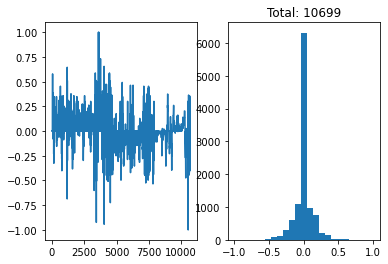

In [3]:
plt.subplot(1,2,1)
sample_count = len(samples)
plotx = np.linspace(0, sample_count-1, sample_count)
ploty = np.array([sample[3] for sample in samples])
plt.plot(plotx, ploty)

plt.subplot(1,2,2)
plt.hist(ploty, bins=23)
plt.title("Total: " + str(sample_count))
plt.show()  

#### Flattening Data Distribution
To prevent overfitting going straight

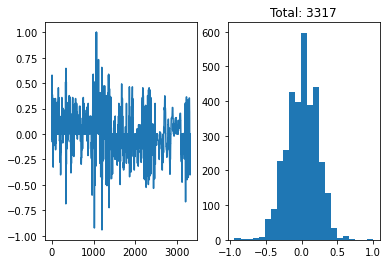

In [4]:
angles = np.array([sample[3] for sample in samples])
num_bin = 23
avg_per_bin = len(angles)/num_bin

hist, bins = np.histogram(angles, num_bin)
keep_probs=[]

# set keep probability for each bin
for i in range(num_bin):
    if hist[i] < avg_per_bin:
        keep_probs.append(1.)
    else:
        keep_probs.append(1.*avg_per_bin/hist[i])
    
# drop samples above average
flatten_samples = []
for sample in samples:
    for j in range(num_bin):
        if sample[3] > bins[j] and sample[3] <= bins[j+1]:
           if np.random.rand() <= keep_probs[j]:
               flatten_samples.append(sample)
           


plt.subplot(1,2,1)
sample_count = len(flatten_samples)
plotx = np.linspace(0, sample_count-1, sample_count)
ploty = np.array([sample[3] for sample in flatten_samples])
plt.plot(plotx, ploty)

plt.subplot(1,2,2)
plt.hist(ploty, bins=23)
plt.title("Total: " + str(sample_count))
plt.show()

### Data Augumentation

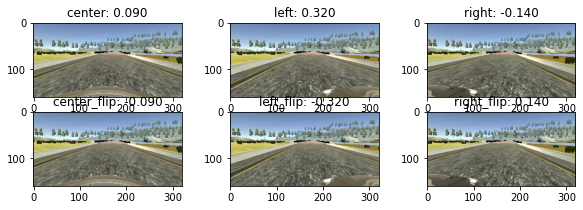

In [16]:
steering_bias = 0.23
title = ['center', 'left', 'right', 'center_flip', 'left_flip', 'right_flip']

sample = samples[70]
img = []
img.append([sample[0], sample[3], False])
img.append([sample[1], sample[3]+steering_bias, False])
img.append([sample[2], sample[3]-steering_bias, False])
img.append([sample[0], -sample[3], True])
img.append([sample[1], -(sample[3]+steering_bias), True])
img.append([sample[2], -(sample[3]-steering_bias), True])

plt.figure(figsize=(10,5))
for i in range(6):
    val_im = plt.imread(img[i][0])
    plt.subplot(2,3,i+1)
    plt.title(f'{title[i]}: {img[i][1]:.3f}')
    plt.imshow(val_im)

plt.show()

Total number of samples: 19902


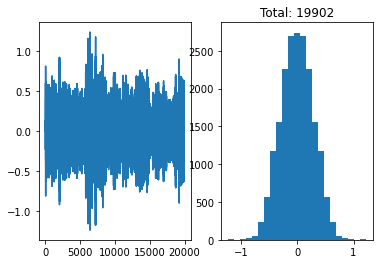

In [5]:
steering_bias = 0.23

augumented_samples = []

for sample in flatten_samples:
    center = [sample[0], sample[3], False]
    left = [sample[1], sample[3]+steering_bias, False]
    right = [sample[2], sample[3]-steering_bias, False]
    center_flip = [sample[0], -sample[3], True]
    left_flip = [sample[1], -(sample[3]+steering_bias), True]
    right_flip = [sample[2], -(sample[3]-steering_bias), True]
    augumented_samples.append(center)
    augumented_samples.append(left)
    augumented_samples.append(right)
    augumented_samples.append(center_flip)
    augumented_samples.append(left_flip)
    augumented_samples.append(right_flip)
    
train_samples, validation_samples = train_test_split(augumented_samples, test_size=0.2)

sample_count = len(augumented_samples)
print("Total number of samples: " + str(sample_count))
plt.subplot(1,2,1)
plotx = np.linspace(0, sample_count-1, sample_count)
ploty = np.array([sample[1] for sample in augumented_samples])
plt.plot(plotx, ploty)
plt.subplot(1,2,2)
plt.title("Total: " + str(sample_count))
plt.hist(ploty, bins=23)
plt.show()

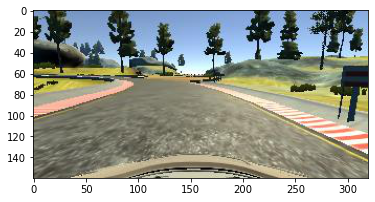

0.2211613


In [6]:
val_im = plt.imread(validation_samples[0][0])
plt.title("Label: "+str(validation_samples[0][1]))
plt.imshow(val_im)
plt.show()

## Training

### Crop Sampling

Visualzing the image cropping. This pre-process is integrated in the second layer of Keras model. You'll be able to see the landscape above horizon and car hood is removed.

Using TensorFlow backend.


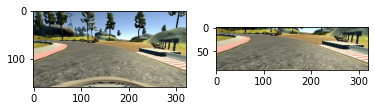

In [7]:
from keras.models import Sequential
from keras.layers import Cropping2D
from keras import backend as K

# Preprocess incoming data.
# Crop 50 rows pixels from the top, 20 rows pixels from the bottom
crop_model = Sequential()
crop_model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
crop_function = K.function([crop_model.layers[0].input], [crop_model.layers[0].output])

# Test on single sample image
image = cv2.cvtColor(cv2.imread(samples[5][0]), cv2.COLOR_BGR2RGB)
crop_image = crop_function([image[None,...]])[0].astype(np.uint8) # make 5d list of 4d numpy tenser

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(crop_image[0, ...])
plt.show()


### Model
This model is inspired by Nvidia model. It has preprocessing layers including crop, normalization and resize.

In [8]:
from keras.models import Sequential
from keras.layers import Lambda, Cropping2D, Conv2D, Flatten, Dense
import tensorflow as tf

model = Sequential()
# Preprocess incoming data.
# Crop 50 rows pixels from the top, 20 rows pixels from the bottom
# Centered around zero within range of [-1, 1]
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x/127.5 - 1.)))
model.add(Lambda(lambda x: tf.image.resize(x, (66,200))))
model.add(Conv2D(24, (5,5), padding="valid", strides=(2,2), activation="relu"))
model.add(Conv2D(36, (5,5), padding="valid", strides=(2,2), activation="relu"))
model.add(Conv2D(48, (5,5), padding="valid", strides=(2,2), activation="relu"))
model.add(Conv2D(64, (3,3), padding="valid", activation="relu"))
model.add(Conv2D(64, (3,3), padding="valid", activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_______________________________________

### Batch Generator

Generator is used to efficiently use limited memory. When calling `fit_generator()` instead of `fit()`, it loads one batch on memory at a time rather than loading a whole dataset at once.

In [9]:
import cv2

def generator(samples, batch_size=32):
    num_samples = len(samples)
    # Epoch Loop
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)

        # Batch Loop
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            # Load image from each sample
            for batch_sample in batch_samples:
                image = cv2.imread(batch_sample[0])
                try:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                except:
                    print(batch_sample[0])
                angle = float(batch_sample[1])
                is_fliped = batch_sample[2]
                
                if is_fliped:
                    image = cv2.flip(image, 1)
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

### Train the Model

In [10]:
from math import ceil

# Set our batch size
batch_size=32
epochs=5

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)
model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, \
            steps_per_epoch=ceil(len(train_samples)/batch_size), \
            validation_data=validation_generator, \
            validation_steps=ceil(len(validation_samples)/batch_size), \
            epochs=epochs, verbose=1)


model.save('model.h5')
np.save('history_object.npy', history_object)

### print the keys contained in the history object
print(history_object.history.keys())

Epoch 1/5
498/498 [==============================] - 31s 62ms/step - loss: 0.0322 - val_loss: 0.0272
Epoch 2/5
498/498 [==============================] - 24s 48ms/step - loss: 0.0230 - val_loss: 0.0140
Epoch 3/5
498/498 [==============================] - 24s 48ms/step - loss: 0.0198 - val_loss: 0.0153
Epoch 4/5
498/498 [==============================] - 24s 48ms/step - loss: 0.0172 - val_loss: 0.0156
Epoch 5/5
498/498 [==============================] - 24s 48ms/step - loss: 0.0152 - val_loss: 0.0102
dict_keys(['val_loss', 'loss'])


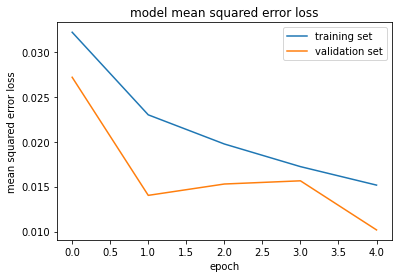

In [11]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()